## 将所有病人的资料拼接到一起
将summary文件的病人信息作为虚拟变量加入到病人数据中

In [31]:
import numpy as np
import pandas as pd
import os
def createXY(dataset,npast,n_future,column_target):
    dataX,dataY=[],[]
    for i in range(npast,dataset.shape[0]-n_future+1):
        dataX.append(dataset.iloc[i-npast:i].values)
        dataY.append(dataset.iloc[i:i+n_future][column_target].values)
    return np.array(dataX),np.array(dataY)

def processFiles(need_columns,target_column,all_df,n_past=1,n_future=1):
    all_x,all_y=np.array([]),np.array([])
    for df in all_df:
        df=df[need_columns]
        x,y=createXY(df,n_past,n_future,target_column)
        all_x=np.vstack([all_x,x]) if all_x.size else x
        all_y=np.vstack([all_y,y]) if all_y.size else y
    return all_x,all_y

def processSummary(summary_columns,summary,folder_path):
    all_df=[]
    for f in os.listdir(folder_path):
        if f.endswith('.xlsx') or f.endswith('.xls'):
            df=pd.read_excel(folder_path+f)
            df['Patient Number']=f.split('.')[0]
            df=pd.merge(df,summary[summary_columns],on='Patient Number')
            
            all_df.append(df)
    return all_df

need_columns=['Date','CGM (mg / dl)','CBG (mg / dl)']
target_column='CGM (mg / dl)'
summary_columns=['Patient Number',
                 'Gender (Female=1, Male=2)',
                 'Age (years)',
                 'BMI (kg/m2)',
                 'Type of Diabetes',
                 'Alcohol Drinking History (drinker/non-drinker)']
need_columns.extend(summary_columns)

summary1=pd.read_excel('./data/Shanghai_T1DM_Summary.xlsx')
summary2=pd.read_excel('./data/Shanghai_T2DM_Summary.xlsx')

summary1['Type of Diabetes']=summary1['Type of Diabetes'].apply(lambda x: 1 if x=='T1DM' else 2)
summary2['Type of Diabetes']=summary2['Type of Diabetes'].apply(lambda x: 1 if x=='T1DM' else 2)

summary1['Alcohol Drinking History (drinker/non-drinker)']=summary1['Alcohol Drinking History (drinker/non-drinker)'].apply(lambda x: 1 if x=='drinker' else 0)
summary2['Alcohol Drinking History (drinker/non-drinker)']=summary2['Alcohol Drinking History (drinker/non-drinker)'].apply(lambda x: 1 if x=='drinker' else 0)


T1df_all=processSummary(summary_columns,summary1,'./data/Shanghai_T1DM/')
T2df_all=processSummary(summary_columns,summary2,'./data/Shanghai_T2DM/')

PAST_HOURS = 6 # 使用过去6小时的数据输入
FUTURE_HOURS = 1 # 预测未来1小时的数据
NPAST, NFUTURE = 4 * PAST_HOURS, 4 * FUTURE_HOURS
all_x,all_y=processFiles(need_columns,target_column,T1df_all+T2df_all,n_past=NPAST,n_future=NFUTURE)


In [32]:
# 把all_x的每一个元素都转换为一个dataframe，表头为need_columns
def to_df(x):
    return pd.DataFrame(x,columns=need_columns)
all_x_df=list(map(to_df,all_x))


# 删除Patient Number属性
for i in range(len(all_x_df)):
    all_x_df[i]=all_x_df[i].drop(columns=['Patient Number'])
need_columns.remove('Patient Number')

# 将Date转换为一天的第几分钟
for i in range(len(all_x_df)):
    all_x_df[i]['Minute']=all_x_df[i]['Date'].apply(lambda x: x.hour*60+x.minute)
    # 使用正余弦函数将Minute转换为周期性特征
    all_x_df[i]['Minute_sin'] = np.sin(2 * np.pi * all_x_df[i]['Minute'] / 1440)
    # 删除Hour列和Date列
    all_x_df[i]=all_x_df[i].drop(columns=['Date','Minute'])

need_columns.remove('Date')
need_columns.append('Minute_sin')

In [33]:
# 将all_x_df中的每个元素元素设置为float类型
all_x_df=[ df.astype(float) for df in all_x_df]
all_x_df[0].head()

,CGM (mg / dl),CBG (mg / dl),"Gender (Female=1, Male=2)",Age (years),BMI (kg/m2),Type of Diabetes,Alcohol Drinking History (drinker/non-drinker),Minute_sin
0,113.4,NaN,1.0,66.0,26.666667,1.0,0.0,-0.944089
1,124.2,NaN,1.0,66.0,26.666667,1.0,0.0,-0.963630
2,129.6,NaN,1.0,66.0,26.666667,1.0,0.0,-0.979045
3,142.2,NaN,1.0,66.0,26.666667,1.0,0.0,-0.990268
4,156.6,NaN,1.0,66.0,26.666667,1.0,0.0,-0.997250


In [34]:
# 剩下的缺失值使用0填充
_all_x_df=[df.fillna(0) for df in all_x_df]
# 输出所有的_all_x_df中每个元素是否有缺失值的汇总
print(pd.Series(map(lambda x: x.isnull().sum().sum(),_all_x_df)).value_counts())

# 对于all_y，使用前一个值填充缺失值
_all_y=pd.DataFrame(all_y).fillna(method='ffill').values
# 输出all_y中的缺失值的个数
print(pd.Series(_all_y.flatten()).isnull().sum())

_all_x_df[0].head()


0    124795
Name: count, dtype: int64
0


C:\Users\dry33\AppData\Local\Temp\ipykernel_5592\2665316325.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  _all_y=pd.DataFrame(all_y).fillna(method='ffill').values


,CGM (mg / dl),CBG (mg / dl),"Gender (Female=1, Male=2)",Age (years),BMI (kg/m2),Type of Diabetes,Alcohol Drinking History (drinker/non-drinker),Minute_sin
0,113.4,0.0,1.0,66.0,26.666667,1.0,0.0,-0.944089
1,124.2,0.0,1.0,66.0,26.666667,1.0,0.0,-0.963630
2,129.6,0.0,1.0,66.0,26.666667,1.0,0.0,-0.979045
3,142.2,0.0,1.0,66.0,26.666667,1.0,0.0,-0.990268
4,156.6,0.0,1.0,66.0,26.666667,1.0,0.0,-0.997250


In [35]:
all_x_df=_all_x_df
all_y=_all_y

# 分割训练集与测试集
from sklearn.model_selection import train_test_split
SpiltRatio=0.7
X_train, X_test, y_train, y_test = train_test_split(all_x_df, all_y, test_size=1-SpiltRatio, random_state=42)

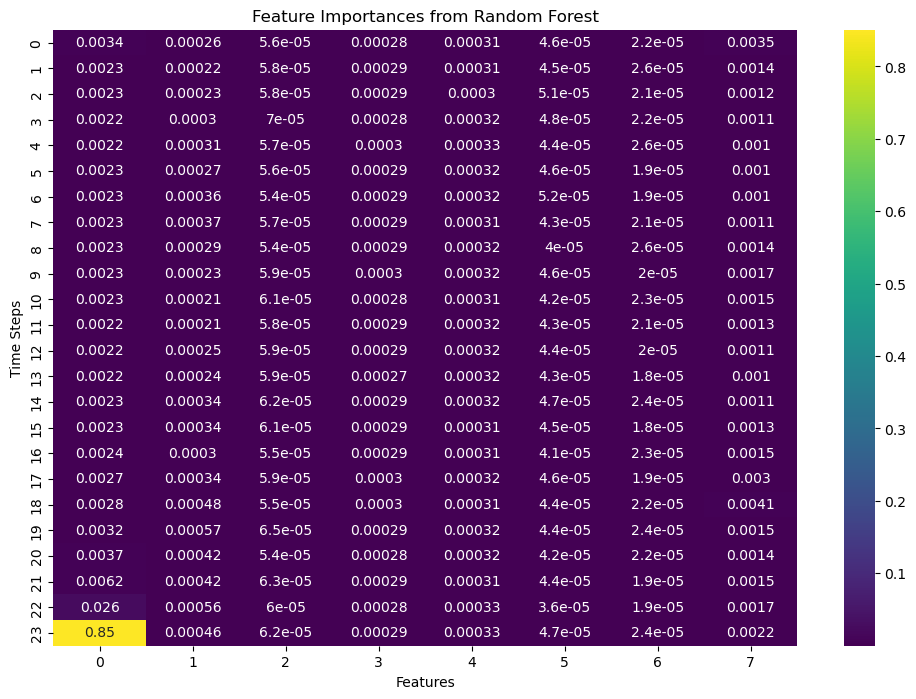

Text(120.72222222222221, 0.5, 'Time Steps')

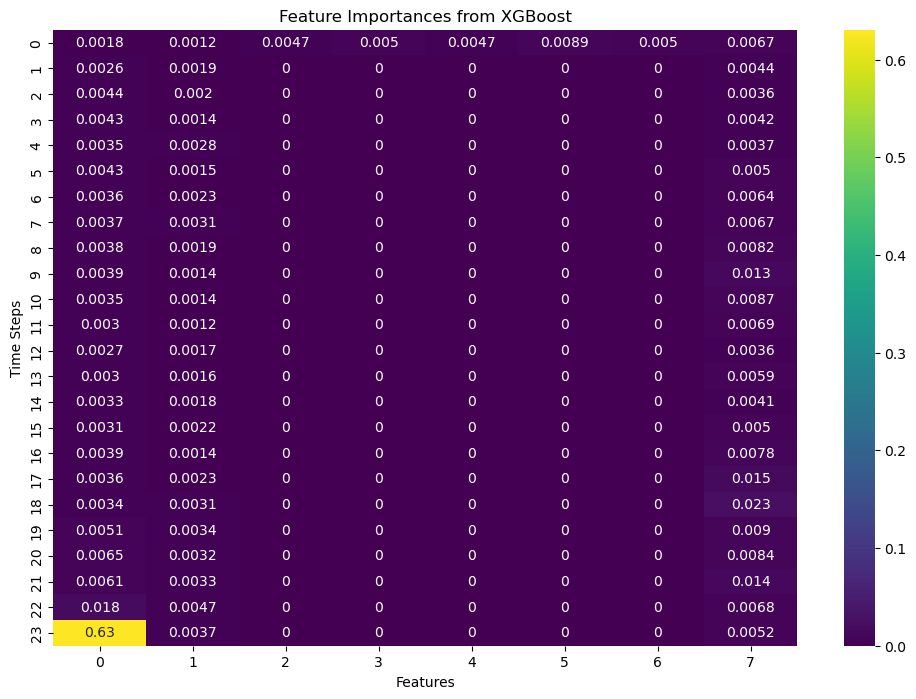

In [43]:
# 使用随机森林与XGBoost进行特征选择
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)

_X_train = np.array(X_train)
_y_train = np.array(y_train)
X_train_flattened  = _X_train.reshape(_X_train.shape[0], -1)

rf_model.fit(X_train_flattened, _y_train)
xgb_model.fit(X_train_flattened, _y_train)

rf_importance = rf_model.feature_importances_
xgb_importance = xgb_model.feature_importances_
# 将重要性重新排列成原始特征的形式 (24, 8)
rf_importance_reshaped = rf_importance.reshape((24, 8))
xgb_importance_reshaped = xgb_importance.reshape((24, 8))

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(rf_importance_reshaped, annot=True, cmap='viridis')
plt.title('Feature Importances from Random Forest')
plt.xlabel('Features')
plt.ylabel('Time Steps')
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(xgb_importance_reshaped, annot=True, cmap='viridis')
plt.title('Feature Importances from XGBoost')
plt.xlabel('Features')
plt.ylabel('Time Steps')
plt.show()  
